In [1]:
#All necessary libraries are imported here, some weren't needed in the final edition but were used in the lifecycle
import pandas as pd
import seaborn as sns
import csv
import numpy as np
import sklearn
import pickle
import xgboost as xgb
from copy import deepcopy
from django.db.models import Model
from IPython.display import display
from pandas.plotting import scatter_matrix
from sklearn import preprocessing
from sklearn.preprocessing import scale
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from time import time
import pylab as plb
import matplotlib.pyplot as plt

#This path variable makes it easier to read CSV files in considering how many times it's done throughout the script
path = 'C:/Users/Admin/premier_predictions/Datasets/'
%matplotlib inline

In [2]:
#Almost 13 seasons of data is read in, all the way from 2007 to the last games that were played,
#as more games are played the 1920 file must be updated
data_season_1 = pd.read_csv(path + '0708.csv')
data_season_2 = pd.read_csv(path + '0809.csv')
data_season_3 = pd.read_csv(path + '0910.csv')
data_season_4 = pd.read_csv(path + '1011.csv')
data_season_5 = pd.read_csv(path + '1112.csv')
data_season_6 = pd.read_csv(path + '1213.csv')
data_season_7 = pd.read_csv(path + '1314.csv')
data_season_8 = pd.read_csv(path + '1415.csv')
data_season_9 = pd.read_csv(path + '1516.csv')
data_season_10 = pd.read_csv(path + '1617.csv')
data_season_11 = pd.read_csv(path + '1718.csv')
data_season_12 = pd.read_csv(path + '1819.csv')
#data_season_current = pd.read_csv(path + '1920.csv')

In [3]:
#When inputting dates into a model it won't read them in the format defined in the file, so once they are read into a df
#the format is change to something processable
data_season_1.Date = pd.to_datetime(data_season_1.Date, format='%d/%m/%Y')
data_season_2.Date = pd.to_datetime(data_season_2.Date, format='%d/%m/%Y')
data_season_3.Date = pd.to_datetime(data_season_3.Date, format='%d/%m/%Y')
data_season_4.Date = pd.to_datetime(data_season_4.Date, format='%d/%m/%Y')
data_season_5.Date = pd.to_datetime(data_season_5.Date, format='%d/%m/%Y')
data_season_6.Date = pd.to_datetime(data_season_6.Date, format='%d/%m/%Y')
data_season_7.Date = pd.to_datetime(data_season_7.Date, format='%d/%m/%Y')
data_season_8.Date = pd.to_datetime(data_season_8.Date, format='%d/%m/%Y')
data_season_9.Date = pd.to_datetime(data_season_9.Date, format='%d/%m/%Y')
data_season_10.Date = pd.to_datetime(data_season_10.Date, format='%d/%m/%Y')
data_season_11.Date = pd.to_datetime(data_season_11.Date, format='%d/%m/%Y')
data_season_12.Date = pd.to_datetime(data_season_12.Date, format='%d/%m/%Y')
#data_season_current.Date = pd.to_datetime(data_season_current.Date, format='%d/%m/%Y')

In [4]:
#The columns are narrowed down to gameplay statistics, i.e. the basic data collected from a match
                      
gameplay_cols = ['Date','HomeTeam','AwayTeam','FTHG','FTAG','FTR']

#These columns are applied to each dataframe, this occurs a lot in the script as functions are created to make more detailed stats
data_season_1 = data_season_1[gameplay_cols]
data_season_2 = data_season_2[gameplay_cols]
data_season_3 = data_season_3[gameplay_cols]
data_season_4 = data_season_4[gameplay_cols]
data_season_5 = data_season_5[gameplay_cols]
data_season_6 = data_season_6[gameplay_cols]
data_season_7 = data_season_7[gameplay_cols]
data_season_8 = data_season_8[gameplay_cols]
data_season_9 = data_season_9[gameplay_cols]
data_season_10 = data_season_10[gameplay_cols]
data_season_11 = data_season_11[gameplay_cols]
data_season_12 = data_season_12[gameplay_cols]
#data_season_current = data_season_current[gameplay_cols]


In [5]:
#This function takes in a dataframe and aims to return the aggregate goals scored for a team
def total_goals_scored(data):
  #This teams dictionary separates each team by the HomeTeam variable so the function applies to each one uniquely
  teams = {key:[0] for key in data.HomeTeam.unique()}
  
  #The home team and away team's goals are added up according to matches in the past
  for i, row in data.iterrows():
    
    teams[row.HomeTeam].append(teams[row.HomeTeam][-1] + row.FTHG) 
    teams[row.AwayTeam].append(teams[row.AwayTeam][-1] + row.FTAG)
  
  #The total goals scored variable is created as empty and is then added to based on each match they played
  data['HTGS'] = 0
  data['ATGS'] = 0
  for i, row in data.iterrows():
    data.at[i, 'HTGS'] = teams[row.HomeTeam].pop(0)
    data.at[i, 'ATGS'] = teams[row.AwayTeam].pop(0)
  
  return data

#Function is applied to each season
data_season_1 = total_goals_scored(data_season_1)
data_season_2 = total_goals_scored(data_season_2)
data_season_3 = total_goals_scored(data_season_3)
data_season_4 = total_goals_scored(data_season_4)
data_season_5 = total_goals_scored(data_season_5)
data_season_6 = total_goals_scored(data_season_6)
data_season_7 = total_goals_scored(data_season_7)
data_season_8 = total_goals_scored(data_season_8)
data_season_9 = total_goals_scored(data_season_9)
data_season_10 = total_goals_scored(data_season_10)
data_season_11 = total_goals_scored(data_season_11)
data_season_12 = total_goals_scored(data_season_12)
#data_season_current = total_goals_scored(data_season_current)

In [6]:
#Same logic applies to getting the total goals conceded
def total_goals_conceded(data):
  teams = {key:[0] for key in data.HomeTeam.unique()}
  
  for i, row in data.iterrows():
    
    teams[row.HomeTeam].append(teams[row.HomeTeam][-1] + row.FTAG)
    teams[row.AwayTeam].append(teams[row.AwayTeam][-1] + row.FTHG)
  
  data['HTGC'] = 0
  data['ATGC'] = 0

  for i, row in data.iterrows():
    data.at[i, 'HTGC'] = teams[row.HomeTeam].pop(0)
    data.at[i, 'ATGC'] = teams[row.AwayTeam].pop(0)
  
  return data

data_season_1 = total_goals_conceded(data_season_1)
data_season_2 = total_goals_conceded(data_season_2)
data_season_3 = total_goals_conceded(data_season_3)
data_season_4 = total_goals_conceded(data_season_4)
data_season_5 = total_goals_conceded(data_season_5)
data_season_6 = total_goals_conceded(data_season_6)
data_season_7 = total_goals_conceded(data_season_7)
data_season_8 = total_goals_conceded(data_season_8)
data_season_9 = total_goals_conceded(data_season_9)
data_season_10 = total_goals_conceded(data_season_10)
data_season_11 = total_goals_conceded(data_season_11)
data_season_12 = total_goals_conceded(data_season_12)
#data_season_current = total_goals_conceded(data_season_current)


In [7]:
#Defining exactly what correlates a home win or away win
def match_points(is_home_team, FTR):
  if FTR == 'H':
    return 3 if is_home_team else 0
  elif FTR == 'A':
    return 0 if is_home_team else 3
  else:
    return 1

#Similar to getting the total goals, now that the results have been defined, we can get the total points per team
def total_points(data):
  teams = {key:[0] for key in data.HomeTeam.unique()}
  
  for i, row in data.iterrows():
    teams[row.HomeTeam].append(teams[row.HomeTeam][-1] + match_points(is_home_team=True, FTR=row.FTR))
    teams[row.AwayTeam].append(teams[row.AwayTeam][-1] + match_points(is_home_team=False, FTR=row.FTR))
    
  data['HTP'] = 0
  data['ATP'] = 0
  for i, row in data.iterrows():
    data.at[i, 'HTP'] = teams[row.HomeTeam].pop(0)
    data.at[i, 'ATP'] = teams[row.AwayTeam].pop(0)
  
  return data

data_season_1 = total_points(data_season_1)
data_season_2 = total_points(data_season_2)
data_season_3 = total_points(data_season_3)
data_season_4 = total_points(data_season_4)
data_season_5 = total_points(data_season_5)
data_season_6 = total_points(data_season_6)
data_season_7 = total_points(data_season_7)
data_season_8 = total_points(data_season_8)
data_season_9 = total_points(data_season_9)
data_season_10 = total_points(data_season_10)
data_season_11 = total_points(data_season_11)
data_season_12 = total_points(data_season_12)
#data_season_current = total_points(data_season_current)


In [8]:
#Defining what constitues a win (W), loss(L) or draw (D) for the home team in a match
def match_results(is_home_team, FTR):
  if FTR == 'H':
    return 'W' if is_home_team else 'L'
  elif FTR == 'A':
    return 'L' if is_home_team else 'W'
  else:
    return 'D'

def form_5_games(data):
  #The key in this dictionary is M as not enough matches have been played yet to build a run of form
  teams = {key:['M'] for key in data.HomeTeam.unique()}
  
  #similar to adding goals up, this loop will add each result on, so form and streaks can be monitored
  for i, row in data.iterrows():
    teams[row.HomeTeam].append(match_results(is_home_team=True, FTR=row.FTR))
    teams[row.AwayTeam].append(match_results(is_home_team=False, FTR=row.FTR))
    
  #using deepcopy to build up a run of form over 5 games
  teams2 = deepcopy(teams)
  teams3 = deepcopy(teams)
  teams4 = deepcopy(teams)
  teams5 = deepcopy(teams)   
  for key in teams:
    teams2[key].insert(0,'M')
    teams3[key].insert(0,'M')
    teams3[key].insert(0,'M')   
    teams4[key].insert(0,'M')
    teams4[key].insert(0,'M')
    teams4[key].insert(0,'M')    
    teams5[key].insert(0,'M')
    teams5[key].insert(0,'M')
    teams5[key].insert(0,'M')
    teams5[key].insert(0,'M')

  #Each teams first 5 games are defined as M as they haven't played them yet
  for i in range(1, 6):
    data['HM' + str(i)] = 'M'
    data['AM' + str(i)] = 'M'
  
  #The last 5 matches played by the home team and away team are added
  for i, row in data.iterrows():
    data.at[i, 'HM5'] = teams5[row.HomeTeam].pop(0)
    data.at[i, 'HM4'] = teams4[row.HomeTeam].pop(0)
    data.at[i, 'HM3'] = teams3[row.HomeTeam].pop(0)
    data.at[i, 'HM2'] = teams2[row.HomeTeam].pop(0)
    data.at[i, 'HM1'] = teams[row.HomeTeam].pop(0)
    
    data.at[i, 'AM5'] = teams5[row.AwayTeam].pop(0)
    data.at[i, 'AM4'] = teams4[row.AwayTeam].pop(0)
    data.at[i, 'AM3'] = teams3[row.AwayTeam].pop(0)
    data.at[i, 'AM2'] = teams2[row.AwayTeam].pop(0)
    data.at[i, 'AM1'] = teams[row.AwayTeam].pop(0)
  
  return data

data_season_1 = form_5_games(data_season_1)
data_season_2 = form_5_games(data_season_2)
data_season_3 = form_5_games(data_season_3)
data_season_4 = form_5_games(data_season_4)
data_season_5 = form_5_games(data_season_5)
data_season_6 = form_5_games(data_season_6)
data_season_7 = form_5_games(data_season_7)
data_season_8 = form_5_games(data_season_8)
data_season_9 = form_5_games(data_season_9)
data_season_10 = form_5_games(data_season_10)
data_season_11 = form_5_games(data_season_11)
data_season_12 = form_5_games(data_season_12)
#data_season_current = form_5_games(data_season_current)


In [9]:
new_cols = ['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 
        'FTAG', 'FTR', 'HTGS', 'ATGS', 'HTGC', 
        'ATGC', 'HTP', 'ATP',
        'HM1', 'HM2', 'HM3', 'HM4', 'HM5', 
        'AM1', 'AM2', 'AM3', 'AM4', 'AM5' ]

data_season_1 = data_season_1[new_cols]
data_season_2 = data_season_2[new_cols]
data_season_3 = data_season_3[new_cols]
data_season_4 = data_season_4[new_cols]
data_season_5 = data_season_5[new_cols]
data_season_6 = data_season_6[new_cols]
data_season_7 = data_season_7[new_cols]
data_season_8 = data_season_8[new_cols]
data_season_9 = data_season_9[new_cols]
data_season_10 = data_season_10[new_cols]
data_season_11 = data_season_11[new_cols]
data_season_12 = data_season_12[new_cols]
#data_season_current = data_season_current[new_cols]


In [10]:
#A file containing each teams previous league position back to 2006,
#if the team has just been promoted, their position from when they were last in the
#league and relegated is used.
prev_positions = pd.read_csv(path + "leaguepositions.csv")
prev_positions.set_index(['Team'], inplace=True)

#Luckily in 2019/20 each team had played in the league at least once since 2006,
#but this fills any year in which a new team starts the league as 18th
prev_positions = prev_positions.fillna(18)

#Given that every other season but the 2019/20 season has been completed,
#this will count only if 380 matches are played
def last_season_pos(data, prev_positions, year):
    HomeTeamLP = []
    AwayTeamLP = []
    for i in range(380):
        ht = data.iloc[i].HomeTeam
        at = data.iloc[i].AwayTeam
        HomeTeamLP.append(prev_positions.loc[ht][year])
        AwayTeamLP.append(prev_positions.loc[at][year])
    data['HomeTeamLP'] = HomeTeamLP
    data['AwayTeamLP'] = AwayTeamLP
    return data

#For the current year, at the time of execution, 288 matches have been played,
#the previous function wouldn't work so this would have to be updated as more matches are played
'''def most_recent_pos(data, prev_positions, year):
    HomeTeamLP = []
    AwayTeamLP = []
    for i in range(288):
        ht = data.iloc[i].HomeTeam
        at = data.iloc[i].AwayTeam
        HomeTeamLP.append(prev_positions.loc[ht][year])
        AwayTeamLP.append(prev_positions.loc[at][year])
    data['HomeTeamLP'] = HomeTeamLP
    data['AwayTeamLP'] = AwayTeamLP
    return data'''

data_season_1 = last_season_pos(data_season_1, prev_positions, 0)
data_season_2 = last_season_pos(data_season_2, prev_positions, 1)
data_season_3 = last_season_pos(data_season_3, prev_positions, 2)
data_season_4 = last_season_pos(data_season_4, prev_positions, 3)
data_season_5 = last_season_pos(data_season_5, prev_positions, 4)
data_season_6 = last_season_pos(data_season_6, prev_positions, 5)
data_season_7 = last_season_pos(data_season_7, prev_positions, 6)
data_season_8 = last_season_pos(data_season_8, prev_positions, 7)
data_season_9 = last_season_pos(data_season_9, prev_positions, 8)
data_season_10 = last_season_pos(data_season_10, prev_positions, 9)
data_season_11 = last_season_pos(data_season_11, prev_positions, 10)
data_season_12 = last_season_pos(data_season_12, prev_positions, 11)

#data_season_current = most_recent_pos(data_season_current, prev_positions, 12)

In [11]:
#The matchweek in which a certain game was played is calculated,
#this becomes important as with the first few matchweeks, 
#form can't really be checked.
def mw(data):
    j = 1
    MatchWeek = []
    for i in range(380):
        MatchWeek.append(j)
        if ((i + 1)% 10) == 0:
            j = j + 1
    data['MW'] = MatchWeek
    return data

'''def mw_19_20(data):
    j = 1
    MatchWeek = []
    for i in range(288):
        MatchWeek.append(j)
        if ((i + 1)% 10) == 0:
            j = j + 1
    data['MW'] = MatchWeek
    return data'''

data_season_1 = mw(data_season_1)
data_season_2 = mw(data_season_2)
data_season_3 = mw(data_season_3)
data_season_4 = mw(data_season_4)
data_season_5 = mw(data_season_5)
data_season_6 = mw(data_season_6)
data_season_7 = mw(data_season_7)
data_season_8 = mw(data_season_8)
data_season_9 = mw(data_season_9)
data_season_10 = mw(data_season_10)
data_season_11 = mw(data_season_11)
data_season_12 = mw(data_season_12)

#data_season_current = mw_19_20(data_season_current)

In [12]:
#Now that extra features have been calculated, each dataframe is added
#on top of each other to create one large dataframe for all matches that have
#been played since the beginning of 2007/08
all_seasons = pd.concat([data_season_1,
                         data_season_2,
                         data_season_3,
                         data_season_4,
                         data_season_5,
                         data_season_6,
                         data_season_8,
                         data_season_9,
                         data_season_10,
                         data_season_11,
                         data_season_12],  ignore_index=True, sort=False)
                         #data_season_current

#The last 5 matches for a team are put together as a string of 5 letters
all_seasons['HTFormPtsStr'] = all_seasons['HM1'] + all_seasons['HM2'] + all_seasons['HM3'] + all_seasons['HM4'] + all_seasons['HM5']
all_seasons['ATFormPtsStr'] = all_seasons['AM1'] + all_seasons['AM2'] + all_seasons['AM3'] + all_seasons['AM4'] + all_seasons['AM5']

#The points from the last 5 matches altogether are calculated and added to the dataframe
def generate_points(result):
  if result == 'W':
    return 3
  elif result == 'D':
    return 1
  else:
    return 0

def sum_points(form):
  sum = 0
  for f in form:
    sum += generate_points(f)
  return sum
  
def form_points(data):
  data['HTFormPts'] = None
  data['ATFormPts'] = None
  for i, row in data.iterrows():
    data.at[i, 'HTFormPts'] = sum_points(row.HTFormPtsStr)
    data.at[i, 'ATFormPts'] = sum_points(row.ATFormPtsStr)
  return data

all_seasons = form_points(all_seasons)

In [13]:
#Winning and losing streaks are defined to track form going into a match
def streaks(data):
  data['HTWinStreak3'] = 0
  data['HTWinStreak5'] = 0
  data['HTLossStreak3'] = 0
  data['HTLossStreak5'] = 0

  data['ATWinStreak3'] = 0
  data['ATWinStreak5'] = 0
  data['ATLossStreak3'] = 0
  data['ATLossStreak5'] = 0
  
  for i, row in data.iterrows():
    if 'WWW' in row.HTFormPtsStr:
      data.at[i, 'HTWinStreak3'] = 1
    if 'WWWWW' in row.HTFormPtsStr:
      data.at[i, 'HTWinStreak5'] = 1
    
    if 'WWW' in row.ATFormPtsStr:
      data.at[i, 'ATWinStreak3'] = 1
    if 'WWWWW' in row.ATFormPtsStr:
      data.at[i, 'ATWinStreak5'] = 1
      
    if 'LLL' in row.HTFormPtsStr:
      data.at[i, 'HTLossStreak3'] = 1
    if 'LLLLL' in row.HTFormPtsStr:
      data.at[i, 'HTLossStreak5'] = 1
      
    if 'LLL' in row.ATFormPtsStr:
      data.at[i, 'ATLossStreak3'] = 1
    if 'LLLLL' in row.ATFormPtsStr:
      data.at[i, 'ATLossStreak5'] = 1
    
  return data

all_seasons = streaks(all_seasons)

In [14]:
#Using the goals scored, the goal difference for a team
#can be calculated, which is a valuable statistic
all_seasons['HTGD'] = all_seasons['HTGS'] - all_seasons['HTGC']
all_seasons['ATGD'] = all_seasons['ATGS'] - all_seasons['ATGC']

#The difference in points between two teams can show the gulf in class
#between them and makes it easier to predict who will win.
all_seasons['DiffPts'] = all_seasons['HTP'] - all_seasons['ATP']

#The difference in points over the last few games is also valuable as a
#team could be having a poor season, but could have won their last 5 matches
all_seasons['DiffFormPts'] = all_seasons['HTFormPts'] - all_seasons['ATFormPts']

#The difference in league position from the previous year also gives an indication
#of who would be likely to win
all_seasons['DiffLP'] = all_seasons['HomeTeamLP'] - all_seasons['AwayTeamLP']


In [15]:
#Every column is added and the dataframe is ready to be exported
all_cols = ['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTGS', 'ATGS',
       'HTGC', 'ATGC', 'HTP', 'ATP', 'HM1', 'HM2', 'HM3', 'HM4', 'HM5', 'AM1',
       'AM2', 'AM3', 'AM4', 'AM5', 'HomeTeamLP', 'AwayTeamLP', 'MW',
       'HTFormPtsStr', 'ATFormPtsStr', 'HTFormPts', 'ATFormPts',
       'HTWinStreak3', 'HTWinStreak5', 'HTLossStreak3', 'HTLossStreak5',
       'ATWinStreak3', 'ATWinStreak5', 'ATLossStreak3', 'ATLossStreak5',
       'HTGD', 'ATGD', 'DiffPts', 'DiffFormPts', 'DiffLP']



all_seasons = all_seasons[all_cols]

In [17]:
all_seasons.to_csv(path + 'full_dataset2.csv')

In [22]:
#This stage prepares the data for an algorithm
original_data = pd.read_csv(path + 'full_dataset2.csv')

#The first 3 games for each team isn't taken into account as they haven't
#built up a streak of form yet
original_data = original_data[original_data.MW > 3]

#For easier reading, each of these irrelevant columns are dropped
original_data.drop(['Unnamed: 0','HomeTeam', 'AwayTeam', 'Date', 'MW', 'HTFormPtsStr', 'ATFormPtsStr', 'FTHG', 'FTAG',
           'HTGS', 'ATGS', 'HTGC', 'ATGC','HomeTeamLP', 'AwayTeamLP','DiffPts','HTFormPts','ATFormPts',
           'HM4','HM5','AM4','AM5','HTLossStreak5','ATLossStreak5','HTWinStreak5','ATWinStreak5',
           'HTWinStreak3','HTLossStreak3','ATWinStreak3','ATLossStreak3'],1, inplace=True)
original_data.head()

,FTR,HTP,ATP,HM1,HM2,HM3,AM1,AM2,AM3,HTGD,ATGD,DiffFormPts,DiffLP
30,H,7,5,D,W,W,W,D,D,2,2,2,-7.0
31,A,1,1,L,L,D,L,D,L,-5,-2,0,0.0
32,D,6,4,L,W,W,D,W,M,2,1,2,-4.0
33,A,4,4,L,D,W,D,W,M,-2,1,0,15.0
34,D,3,6,W,L,M,W,W,L,-1,3,-3,-3.0


In [23]:
#Basic statistic trends across the 13 years are calculated to give an
#idea of how the data is spread
number_of_matches = original_data.shape[0]

number_of_homewins = len(original_data[original_data.FTR == 'H'])
number_of_awaywins = len(original_data[original_data.FTR == 'A'])
number_of_draws = len(original_data[original_data.FTR == 'D'])

homewin_rate = (float(number_of_homewins) / (number_of_matches)) * 100
awaywin_rate = (float(number_of_awaywins) / (number_of_matches)) * 100
draw_rate = (float(number_of_draws) / (number_of_matches)) * 100

print ("Total number of matches: {}".format(number_of_matches))

print ("Number of matches won by home team: {}".format(number_of_homewins))
print ("Number of matches won by away team: {}".format(number_of_awaywins))
print ("Number of matches drawn: {}".format(number_of_draws))

print ("Win rate of home team: {:.2f}%".format(homewin_rate))
print ("Win rate of away team: {:.2f}%".format(awaywin_rate))
print ("Draw rate: {:.2f}%".format(draw_rate))


Total number of matches: 3850
Number of matches won by home team: 1791
Number of matches won by away team: 1084
Number of matches drawn: 975
Win rate of home team: 46.52%
Win rate of away team: 28.16%
Draw rate: 25.32%


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002B8850E0828>,
      dtype=object)

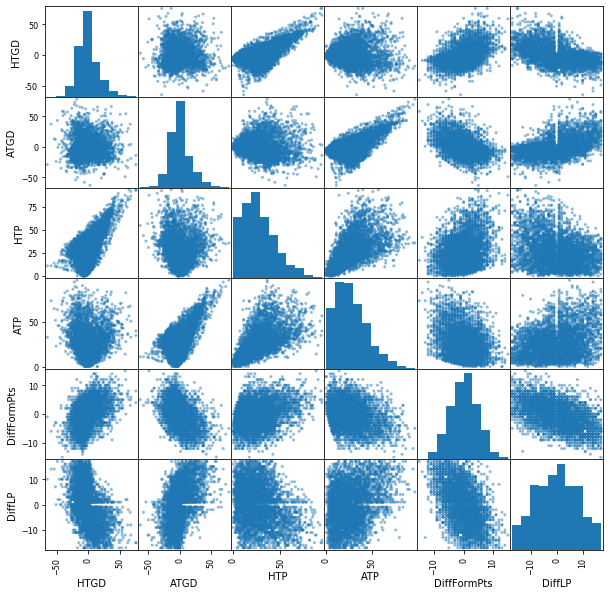

In [24]:
scatter_matrix(original_data[['HTGD','ATGD','HTP','ATP','DiffFormPts','DiffLP']], figsize=(10,10))

In [25]:
#The dataset has to be split in order to isolate the target, which is FTR
x_set = original_data.drop(['FTR'],1)
y_set = original_data['FTR']

#Previously set up features are added to x_set to aid the prediction
needed_cols = [['HTGD','ATGD','HTP','ATP','DiffLP']]
for col in needed_cols:
    x_set[col] = scale(x_set[col])
#The sets data types are checked before preprocessing to avoid errors
x_set.dtypes

HTP            float64
ATP            float64
HM1             object
HM2             object
HM3             object
AM1             object
AM2             object
AM3             object
HTGD           float64
ATGD           float64
DiffFormPts      int64
DiffLP         float64
dtype: object

In [26]:
#Each match used in a streak is changed so it can be preprocessed properly
x_set.HM1 = x_set.HM1.astype('str')
x_set.HM2 = x_set.HM2.astype('str')
x_set.HM3 = x_set.HM3.astype('str')
x_set.AM1 = x_set.AM1.astype('str')
x_set.AM2 = x_set.AM2.astype('str')
x_set.AM3 = x_set.AM3.astype('str')

def preprocessing(x):
    output = pd.DataFrame(index = x.index)
    
    #Each object is changed to an integer
    for col, col_data in x.iteritems():
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix = col)
        output = output.join(col_data)
    return output

x_set = preprocessing(x_set)
#These two columns are dropped as they are irrelevant, we want to see the results only
x_set = x_set.drop(['HM3_M', 'AM3_M'],1)

#This statement confirms that the relevant columns were preprocessed
print ("({} total features)\n{}".format(len(x_set.columns), list(x_set.columns)))

(24 total features)
['HTP', 'ATP', 'HM1_D', 'HM1_L', 'HM1_W', 'HM2_D', 'HM2_L', 'HM2_W', 'HM3_D', 'HM3_L', 'HM3_W', 'AM1_D', 'AM1_L', 'AM1_W', 'AM2_D', 'AM2_L', 'AM2_W', 'AM3_D', 'AM3_L', 'AM3_W', 'HTGD', 'ATGD', 'DiffFormPts', 'DiffLP']


In [27]:
#Double checking the new data types
x_set.dtypes

HTP            float64
ATP            float64
HM1_D            uint8
HM1_L            uint8
HM1_W            uint8
HM2_D            uint8
HM2_L            uint8
HM2_W            uint8
HM3_D            uint8
HM3_L            uint8
HM3_W            uint8
AM1_D            uint8
AM1_L            uint8
AM1_W            uint8
AM2_D            uint8
AM2_L            uint8
AM2_W            uint8
AM3_D            uint8
AM3_L            uint8
AM3_W            uint8
HTGD           float64
ATGD           float64
DiffFormPts      int64
DiffLP         float64
dtype: object

In [28]:
#Both sets are split into training and test sets
#The last 50 games are used as a test and not randomised
x_train, x_test, y_train, y_test = train_test_split(x_set, y_set,
                                                    test_size = 190,
                                                    shuffle = False)


In [29]:
#These are the fixtures to be tested
x_test

,HTP,ATP,HM1_D,HM1_L,HM1_W,HM2_D,HM2_L,HM2_W,HM3_D,HM3_L,...,AM2_D,AM2_L,AM2_W,AM3_D,AM3_L,AM3_W,HTGD,ATGD,DiffFormPts,DiffLP
3990,-0.301159,-0.032504,1,0,0,0,1,0,0,1,...,0,1,0,0,1,0,-0.353858,0.107869,-1,0.868680
3991,-0.927495,-1.003033,1,0,0,1,0,0,0,1,...,0,1,0,0,1,0,-1.569809,-1.353794,3,0.248424
3992,0.040479,-0.717583,0,0,1,0,0,1,0,1,...,0,1,0,0,1,0,0.132523,-1.231989,3,-1.116138
3993,1.350091,0.595485,0,0,1,0,0,1,0,0,...,0,0,1,0,1,0,2.199640,0.960506,7,-0.247780
3994,1.008453,-0.089594,0,0,1,0,0,1,0,0,...,0,1,0,0,0,1,1.470069,-0.135742,5,-1.860444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4175,3.798496,1.680194,0,0,1,0,0,1,0,0,...,0,0,1,0,0,1,3.962770,0.168771,5,-1.736393
4176,2.204186,0.195856,1,0,0,1,0,0,0,1,...,0,1,0,0,1,0,0.801296,-2.267333,2,-1.984495
4177,0.609875,-0.717583,0,1,0,1,0,0,1,0,...,0,1,0,0,1,0,-1.205024,-3.302678,4,0.124373
4178,2.431944,1.451834,0,1,0,0,1,0,0,0,...,1,0,0,0,0,1,1.713260,0.473285,-4,-0.619933


In [30]:
#These functions will determine which is the quickest, and most accurate
#model on both the training set and test set
def classifier_training(clf, x_train, y_train):
    start = time()
    clf.fit(x_train, y_train)
    end = time()
    
    print ("Takes {:.4f} seconds to train".format(end - start))
    
def labels_prediction(clf, features, target):
    start = time()
    y_prediction = clf.predict(features)
    end = time()
    
    print ("Takes {:.4f} seconds to predict".format(end - start))
    
    return f1_score(target, y_prediction, pos_label='H', average='micro'), sum(target == y_prediction) / float(len(y_prediction))

def train_predictor(clf, x_train, y_train, x_test, y_test):
    print ("Model used: {}".format(clf.__class__.__name__))
    
    classifier_training(clf, x_train, y_train)
    
    f1, acc = labels_prediction(clf, x_train, y_train)
    print (f1, acc)
    print ("F1 and accuracy score for training set: {:.4f} , {:.4f}.".format(f1 , acc))
    
    f1, acc = labels_prediction(clf, x_test, y_test)
    print ("F1 and accuracy score for test set: {:.4f} , {:.4f}.".format(f1 , acc))
    

In [31]:
#Each model is taken from scikit-learn and applied accordingly
#as one code block to directly compare
dectree = tree.DecisionTreeClassifier(criterion='entropy')
supvec = SVC(random_state = 912, kernel = 'rbf', gamma = 'scale')
lr = LogisticRegression(random_state = 42)
xgboost = xgb.XGBClassifier(seed = 82)

train_predictor(dectree, x_train, y_train, x_test, y_test)
print ('')
train_predictor(supvec, x_train, y_train, x_test, y_test)
print ('')
train_predictor(lr, x_train, y_train, x_test, y_test)
print ('')
train_predictor(xgboost, x_train, y_train, x_test, y_test)
print ('')

Model used: DecisionTreeClassifier
Takes 0.0860 seconds to train
Takes 0.0060 seconds to predict
1.0 1.0
F1 and accuracy score for training set: 1.0000 , 1.0000.
Takes 0.0030 seconds to predict
F1 and accuracy score for test set: 0.4211 , 0.4211.

Model used: SVC


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1259: UserWarning: Note that pos_label (set to 'H') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1259: UserWarning: Note that pos_label (set to 'H') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


Takes 1.3743 seconds to train
Takes 1.4213 seconds to predict
0.5407103825136612 0.5407103825136612
F1 and accuracy score for training set: 0.5407 , 0.5407.
Takes 0.0380 seconds to predict
F1 and accuracy score for test set: 0.5684 , 0.5684.

Model used: LogisticRegression
Takes 0.0540 seconds to train
Takes 0.0030 seconds to predict
0.5327868852459017 0.5327868852459017
F1 and accuracy score for training set: 0.5328 , 0.5328.
Takes 0.0020 seconds to predict
F1 and accuracy score for test set: 0.5947 , 0.5947.

Model used: XGBClassifier


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1259: UserWarning: Note that pos_label (set to 'H') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1259: UserWarning: Note that pos_label (set to 'H') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning

Takes 4.2021 seconds to train
Takes 0.1020 seconds to predict
0.9762295081967213 0.9762295081967213
F1 and accuracy score for training set: 0.9762 , 0.9762.
Takes 0.0050 seconds to predict
F1 and accuracy score for test set: 0.5158 , 0.5158.



In [53]:
#While the accuracy across all 4 isn't the best, the most ideal
#given its performance on the training set is XGBoost.
#By tuning the hyperparameters correctly, an increase in accuracy is possible
parameters = { 'learning_rate' : [0.25],
               'max_depth': [3],
               'min_child_weight': [5],
               'gamma':[0.4],
               'colsample_bytree' : [0.3],
             }

clf = xgb.XGBClassifier(seed=2)

f1_measure = make_scorer(f1_score,pos_label='H',average='micro')

grid = GridSearchCV(clf,
                    scoring=f1_measure,
                    param_grid=parameters,
                    cv=5)

grid = grid.fit(x_train,y_train)

clf = grid.best_estimator_
print (clf)

f1, acc = labels_prediction(clf, x_train, y_train)
print ("F1 score and accuracy score for training set: {:.4f} , {:.4f}.".format(f1 , acc))

f1, acc = labels_prediction(clf, x_test, y_test)
print ("F1 score and accuracy score for test set: {:.4f} , {:.4f}.".format(f1 , acc))


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1259: UserWarning: Note that pos_label (set to 'H') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0.4, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.25, max_delta_step=0, max_depth=3,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=2, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=2, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)
Takes 0.0330 seconds to predict
F1 score and accuracy score for training set: 0.6025 , 0.6025.
Takes 0.0050 seconds to predict
F1 score and accuracy score for test set: 0.6000 , 0.6000.


In [70]:
df = pd.read_csv(path + 'full_dataset2.csv')

In [88]:
test = df[3990:]

In [89]:
test

,Unnamed: 0,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTGS,ATGS,HTGC,...,HTLossStreak5,ATWinStreak3,ATWinStreak5,ATLossStreak3,ATLossStreak5,HTGD,ATGD,DiffPts,DiffFormPts,DiffLP
3990,3990,2018-12-29,Brighton,Everton,1,0,H,21,31,27,...,0,0,0,0,0,-6,2,-5,-1,7.0
3991,3991,2018-12-29,Fulham,Huddersfield,1,0,H,17,12,43,...,0,0,0,1,1,-26,-22,1,3,2.0
3992,3992,2018-12-29,Leicester,Cardiff,0,1,A,24,18,22,...,0,0,0,0,0,2,-20,13,3,-9.0
3993,3993,2018-12-29,Liverpool,Arsenal,5,1,H,43,41,7,...,0,0,0,0,0,36,16,13,7,-2.0
3994,3994,2018-12-29,Tottenham,Wolves,1,3,A,42,20,18,...,0,1,0,0,0,24,-2,19,5,-15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4175,4175,2019-05-12,Liverpool,Wolves,2,0,H,87,47,22,...,0,1,0,0,0,65,3,37,5,-14.0
4176,4176,2019-05-12,Man United,Cardiff,0,2,A,65,32,52,...,0,0,0,1,0,13,-37,35,2,-16.0
4177,4177,2019-05-12,Southampton,Huddersfield,1,1,D,44,21,64,...,0,0,0,1,0,-20,-54,23,4,1.0
4178,4178,2019-05-12,Tottenham,Everton,2,2,D,65,52,37,...,0,0,0,0,0,28,8,17,-4,-5.0


In [90]:
test.drop(['Unnamed: 0', 'HTFormPtsStr', 'ATFormPtsStr', 'FTHG', 'FTAG',
           'HTGS', 'ATGS', 'HTGC', 'ATGC','HomeTeamLP', 'AwayTeamLP','DiffPts','HTFormPts','ATFormPts',
           'HM4','HM5','AM4','AM5','HTLossStreak5','ATLossStreak5','HTWinStreak5','ATWinStreak5',
           'HTWinStreak3','HTLossStreak3','ATWinStreak3','ATLossStreak3','HTP','ATP','HM1','HM2',
           'HM3','AM1','AM2','AM3','HTGD','ATGD','DiffFormPts','DiffLP'],1, inplace=True)


In [91]:
test.to_csv(path + 'test.csv')

In [92]:
predictions_1819 = pd.DataFrame(clf.predict(x_test))
predictions_1819

,0
0,A
1,A
2,H
3,H
4,H
...,...
185,H
186,H
187,H
188,H


In [93]:
test = pd.read_csv(path + 'test.csv')
test.drop(['Unnamed: 0'],1)

,Date,HomeTeam,AwayTeam,FTR,MW
0,2018-12-29,Brighton,Everton,H,20
1,2018-12-29,Fulham,Huddersfield,H,20
2,2018-12-29,Leicester,Cardiff,A,20
3,2018-12-29,Liverpool,Arsenal,H,20
4,2018-12-29,Tottenham,Wolves,A,20
...,...,...,...,...,...
185,2019-05-12,Liverpool,Wolves,H,38
186,2019-05-12,Man United,Cardiff,A,38
187,2019-05-12,Southampton,Huddersfield,D,38
188,2019-05-12,Tottenham,Everton,D,38


In [100]:
secondhalf_1819 = test.join(predictions_1819)
full_test = secondhalf_1819.drop(['FTR'],1).rename(columns={0:"PRED"})

In [98]:
full_test.to_csv(path + '1819pred_nouser.csv')

In [103]:
full_test.drop(['Unnamed: 0'],1)

,Date,HomeTeam,AwayTeam,MW,PRED
0,2018-12-29,Brighton,Everton,20,A
1,2018-12-29,Fulham,Huddersfield,20,A
2,2018-12-29,Leicester,Cardiff,20,H
3,2018-12-29,Liverpool,Arsenal,20,H
4,2018-12-29,Tottenham,Wolves,20,H
...,...,...,...,...,...
185,2019-05-12,Liverpool,Wolves,38,H
186,2019-05-12,Man United,Cardiff,38,H
187,2019-05-12,Southampton,Huddersfield,38,H
188,2019-05-12,Tottenham,Everton,38,H
